In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
import graphviz
from sklearn.preprocessing import StandardScaler

#matplotlib 패키지 한글 깨짐 처리 시작
#한글 폰트(맑은 고딕) 적용 : 윈도우, 구글 콜랩
matplotlib.rc('font', family = "Malgun Gothic")
plt.rc('font', family = "Malgun Gothic")

#seaborn에서 한글 깨짐 해결
#minus 깨짐현상 방지
plt.rcParams['axes.unicode_minus'] = False

from sklearn.tree import export_graphviz

import graphviz

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, roc_curve, auc, precision_score, recall_score, classification_report

from imblearn.under_sampling import *

### 데이터 불러오기

In [2]:
df = pd.read_pickle('loan_prepared_for_dt.pickle')

In [3]:
#더미변수를 합친 미리 저장한 데이터 불러오기
df2 = pd.read_pickle('all_data.pickle')

In [4]:
df2 = df2[['funded_amnt', 'total_pymnt', 'total_rec_int']]

In [5]:
loan = pd.concat([df, df2], axis=1, join = 'inner')

In [6]:
loan.tail()

,loan_amnt,annual_inc,dti,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,...,addr_state_44,addr_state_45,addr_state_46,addr_state_47,addr_state_48,addr_state_49,addr_state_50,funded_amnt,total_pymnt,total_rec_int
1092914,24000,79000.0,3.90,1,5,0,8621,0.845,23,0,...,0,0,0,0,0,0,0,24000,28663.68666,4663.69
1092915,10000,31000.0,28.69,0,9,1,14037,0.821,15,0,...,0,0,0,0,0,0,0,10000,11947.24405,1947.24
1092916,12000,64400.0,27.19,2,17,0,8254,0.306,20,1,...,0,0,0,0,0,0,0,12000,5366.99000,2234.98
1092917,13000,35000.0,30.90,0,9,1,11031,0.613,22,0,...,0,0,0,0,0,0,0,13000,6109.52000,2506.32
1092918,20000,100000.0,10.83,1,8,1,33266,0.798,10,0,...,0,0,0,0,0,0,0,20000,23735.38633,3735.39


In [7]:
sum(loan.isnull().sum())

0

### train, test 분리

In [8]:
loan_train_val, loan_test =  train_test_split(loan, test_size = 0.2, shuffle=True, random_state=42)
loan_train, loan_val =  train_test_split(loan_train_val, test_size = 0.25, shuffle=True, random_state=42)

In [9]:
df_train_x = loan_train.drop('depvar', axis=1)
df_test_x = loan_test.drop('depvar', axis=1)
df_val_x = loan_val.drop('depvar', axis = 1)
df_train_y = loan_train['depvar'].astype('int')
df_val_y = loan_val['depvar'].astype('int')
df_test_y = loan_test['depvar'].astype('int')

<AxesSubplot:xlabel='depvar', ylabel='count'>

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


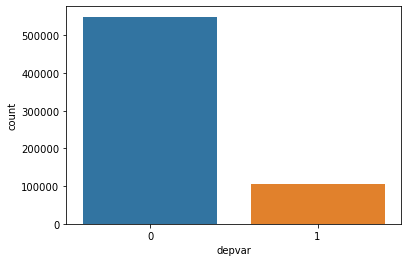

In [10]:
sns.countplot(x = 'depvar', data = loan_train)

In [11]:
df_train_y.value_counts()

0    549680
1    105964
Name: depvar, dtype: int64

In [12]:
df_test_y.value_counts()

0    183087
1     35462
Name: depvar, dtype: int64

In [13]:
print(len(df_train_x), len(df_val_x), len(df_test_x))

655644 218548 218549


In [14]:
from imblearn.under_sampling import *

### 모델 생성

In [15]:
#under sampling 으로 data 균형 맞춰주기
print('before undersampling counts of label 1 : {}'.format(sum(df_train_y == 1)))
print('before undersampling counts of label 0 : {}'.format(sum(df_train_y == 0)))

rus = RandomUnderSampler(random_state = 1234)
x_train_res, y_train_res = rus.fit_resample(df_train_x, df_train_y.ravel())

print('after undersampling counts of label 1 : {}'.format(sum(y_train_res == 1)))
print('after undersampling counts of label 0 : {}'.format(sum(y_train_res == 0)))

before undersampling counts of label 1 : 105964
before undersampling counts of label 0 : 549680
after undersampling counts of label 1 : 105964
after undersampling counts of label 0 : 105964


<AxesSubplot:xlabel='0', ylabel='count'>

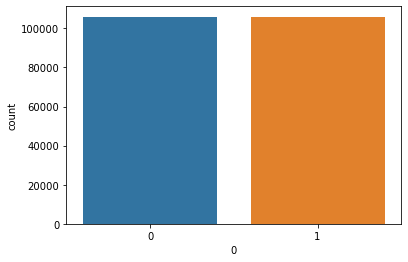

In [16]:
sns.countplot(x = 0, data = pd.DataFrame(y_train_res))

In [17]:
list(x_train_res.columns)[-3:]

['funded_amnt', 'total_pymnt', 'total_rec_int']

In [18]:
model_list = list(x_train_res.columns)
del model_list[-3:]
print(model_list)

['loan_amnt', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'fico_score', 'last_fico_score', 'emp_length_1', 'emp_length_2', 'emp_length_3', 'home_ownership_1', 'home_ownership_2', 'home_ownership_3', 'verification_status_1', 'verification_status_2', 'purpose_1', 'purpose_2', 'purpose_3', 'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8', 'purpose_9', 'purpose_10', 'purpose_11', 'purpose_12', 'purpose_13', 'addr_state_1', 'addr_state_2', 'addr_state_3', 'addr_state_4', 'addr_state_5', 'addr_state_6', 'addr_state_7', 'addr_state_8', 'addr_state_9', '

In [19]:
x_train_res1 = x_train_res.copy()
df_test_x1 = df_test_x.copy()
df_val_x1 = df_val_x.copy()

In [20]:
print(len(x_train_res1), len(df_test_x1), len(df_val_x1))

211928 218549 218548


In [21]:
x_train_res = x_train_res[model_list]
df_test_x = df_test_x[model_list]
df_val_x = df_val_x[model_list]

In [22]:
#기본 tree 모형 생성
dt_uncustomized = DecisionTreeClassifier(random_state = 1234)
dt_uncustomized.fit(x_train_res, y_train_res)

print('Score on training set:{:.3f}'.format(dt_uncustomized.score(x_train_res,
                                                                   y_train_res)))
print('Score on validation set:{:.3f}'.format(dt_uncustomized.score(df_val_x,
                                                              df_val_y)))

Score on training set:1.000
Score on validation set:0.795


### 파라미터 조정

In [23]:
train_score=[]
val_score=[]

para_leaf=[n_leaf*1 for n_leaf in range(1, 20)]

for v_min_samples_leaf in para_leaf:
    tree=DecisionTreeClassifier(random_state=1234, min_samples_leaf=v_min_samples_leaf)
    tree.fit(x_train_res, y_train_res)
    train_score.append(tree.score(x_train_res, y_train_res))
    val_score.append(tree.score(df_val_x, df_val_y))
    
df_score_leaf=pd.DataFrame()
df_score_leaf['MinSamplesLeaf']=para_leaf
df_score_leaf['TrainScore']=train_score
df_score_leaf['TestScore']=val_score

In [24]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,0.795
1,2,0.970,0.809
2,3,0.955,0.804
3,4,0.939,0.815
4,5,0.929,0.813
5,6,0.920,0.819
6,7,0.914,0.819
7,8,0.907,0.825
8,9,0.903,0.825
9,10,0.900,0.827


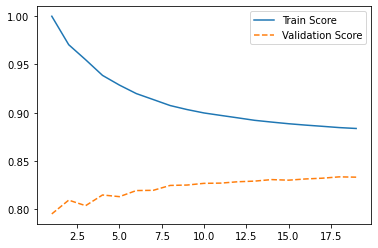

In [25]:
plt.plot(para_leaf, train_score, linestyle='-', label='Train Score')
plt.plot(para_leaf, val_score, linestyle='--', label = 'Validation Score')
plt.legend()
#leaf 10으로 설정

In [26]:
train_score=[]
val_score=[]

para_split=[n_split*2 for n_split in range(2, 20)]

for v_min_samples_split in para_split:
    tree=DecisionTreeClassifier(random_state=1234, min_samples_leaf=12,
                               min_samples_split=v_min_samples_split)
    tree.fit(x_train_res, y_train_res)
    train_score.append(tree.score(x_train_res, y_train_res))
    val_score.append(tree.score(df_val_x, df_val_y))
    
df_score_split=pd.DataFrame()
df_score_split['MinSamplesSplit']=para_split
df_score_split['TrainScore']=train_score
df_score_split['ValScore']=val_score

In [27]:
df_score_split.round(3)

,MinSamplesSplit,TrainScore,ValScore
0,4,0.895,0.828
1,6,0.895,0.828
2,8,0.895,0.828
3,10,0.895,0.828
4,12,0.895,0.828
5,14,0.895,0.828
6,16,0.895,0.828
7,18,0.895,0.828
8,20,0.895,0.828
9,22,0.895,0.828


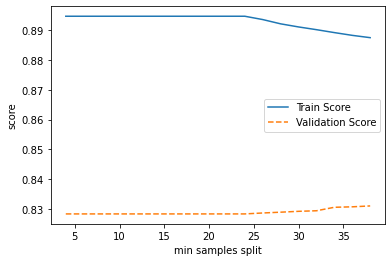

In [28]:
plt.plot(para_split, train_score, linestyle='-', label='Train Score')
plt.plot(para_split, val_score, linestyle='--', label = 'Validation Score')
plt.xlabel('min samples split')
plt.ylabel('score')
plt.legend()

In [29]:
train_score=[]
val_score=[]

para_depth=[depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    tree=DecisionTreeClassifier(random_state=1234, min_samples_leaf=12,
                               min_samples_split=20, max_depth=v_max_depth)
    tree.fit(x_train_res, y_train_res)
    train_score.append(tree.score(x_train_res, y_train_res))
    val_score.append(tree.score(df_val_x, df_val_y))
    
df_score_depth=pd.DataFrame()
df_score_depth['Depth']=para_depth
df_score_depth['TrainScore']=train_score
df_score_depth['ValScore']=val_score

In [30]:
df_score_depth.round(3)

,Depth,TrainScore,ValScore
0,1,0.858,0.822
1,2,0.858,0.822
2,3,0.858,0.822
3,4,0.861,0.842
4,5,0.861,0.846
5,6,0.863,0.837
6,7,0.864,0.837
7,8,0.865,0.836
8,9,0.867,0.838
9,10,0.870,0.837


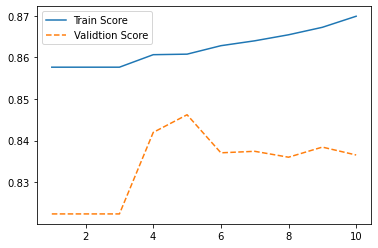

In [31]:
plt.plot(para_depth, train_score, linestyle='-', label='Train Score')
plt.plot(para_depth, val_score, linestyle='--', label = 'Validtion Score')
plt.legend()
#depth 4 로 설정

### 최종 모형

In [32]:
tree_final = DecisionTreeClassifier(min_samples_leaf = 12, min_samples_split = 20, max_depth = 8, random_state=1234)
tree_final_fit = tree_final.fit(x_train_res, y_train_res)

### 결과

In [33]:
y_pred = tree_final.predict(df_val_x)

fpr, tpr, thresholds = roc_curve(df_val_y, y_pred)
roc_auc = auc(fpr, tpr)

print('ROC curve AUC : ', roc_auc)
print('F1-Score : ', f1_score(df_val_y, y_pred))

print('Accuracy on training set : {:.3f}'.format(tree_final.score(x_train_res, y_train_res)))
print('Accuracy on test set : {:.3f}'.format(tree_final.score(df_val_x, df_val_y)))
print('Confusion Matrix : \n {}'.format(confusion_matrix(df_val_y, y_pred)))

ROC curve AUC :  0.8635890345290353
F1-Score :  0.640967331523427
Accuracy on training set : 0.865
Accuracy on test set : 0.836
Confusion Matrix : 
 [[150718  32456]
 [  3383  31991]]


In [34]:
#1을 예측할 확률 계산
result = pd.DataFrame(tree_final_fit.predict_proba(df_val_x))
result['funded_amnt'] = df_val_x1['funded_amnt'].reset_index(drop = True)
result['total_pymnt'] = df_val_x1['total_pymnt'].reset_index(drop = True)
result['total_rec_int'] = df_val_x1['total_rec_int'].reset_index(drop = True)
result

,0,1,funded_amnt,total_pymnt,total_rec_int
0,0.820327,0.179673,35000,50493.590070,15493.59
1,0.994163,0.005837,25000,27312.968610,2312.97
2,0.940323,0.059677,10000,12019.446630,2019.45
3,0.068689,0.931311,28200,20049.640000,5345.28
4,0.964113,0.035887,8000,9003.234163,1003.23
...,...,...,...,...,...
218543,0.915556,0.084444,39400,46655.197130,7255.20
218544,0.472401,0.527599,11200,17187.742020,5987.74
218545,0.948506,0.051494,25000,34290.913550,9290.91
218546,0.829305,0.170695,21000,22221.074110,1221.07


### custom threshold function 모형 2

In [35]:
fpr,tpr,thresholds = roc_curve(df_val_y, result.iloc[:,1:2])

In [36]:
#예측 확률과 실제 label data frame 생성
result['df_val_y'] = pd.DataFrame(df_val_y).reset_index(drop = True)
result

,0,1,funded_amnt,total_pymnt,total_rec_int,df_val_y
0,0.820327,0.179673,35000,50493.590070,15493.59,0
1,0.994163,0.005837,25000,27312.968610,2312.97,0
2,0.940323,0.059677,10000,12019.446630,2019.45,0
3,0.068689,0.931311,28200,20049.640000,5345.28,1
4,0.964113,0.035887,8000,9003.234163,1003.23,0
...,...,...,...,...,...,...
218543,0.915556,0.084444,39400,46655.197130,7255.20,0
218544,0.472401,0.527599,11200,17187.742020,5987.74,0
218545,0.948506,0.051494,25000,34290.913550,9290.91,0
218546,0.829305,0.170695,21000,22221.074110,1221.07,0


In [37]:
result['tot'] = result['funded_amnt'] - result['total_pymnt']
result

,0,1,funded_amnt,total_pymnt,total_rec_int,df_val_y,tot
0,0.820327,0.179673,35000,50493.590070,15493.59,0,-15493.590070
1,0.994163,0.005837,25000,27312.968610,2312.97,0,-2312.968610
2,0.940323,0.059677,10000,12019.446630,2019.45,0,-2019.446630
3,0.068689,0.931311,28200,20049.640000,5345.28,1,8150.360000
4,0.964113,0.035887,8000,9003.234163,1003.23,0,-1003.234163
...,...,...,...,...,...,...,...
218543,0.915556,0.084444,39400,46655.197130,7255.20,0,-7255.197130
218544,0.472401,0.527599,11200,17187.742020,5987.74,0,-5987.742020
218545,0.948506,0.051494,25000,34290.913550,9290.91,0,-9290.913550
218546,0.829305,0.170695,21000,22221.074110,1221.07,0,-1221.074110


In [38]:
#최적 threshold 찾기 

#fpr, tpr, threshold 로 구성된 dataframe 생성하기
roc_result = pd.DataFrame([fpr,tpr,thresholds], index=['fpr','tpr','thresholds']).T
# (1-fpr)+(tpr)값을 계산하여 'best'라는 이름의 칼럼 생성하기
# roc_result['best'] = (1-roc_result.fpr)+(roc_result.tpr) # specificity + sensitivity
# 이 best를 계산하는 방법은 여러가지가 있습니다. 우리는 Youden Index를 기준으로 합니다. (정답은 없음)
# roc_result = roc_result[roc_result['thresholds'] < 1]
roc_result

,fpr,tpr,thresholds
0,0.000000,0.000000,1.976411
1,0.000868,0.021711,0.976411
2,0.001032,0.024934,0.972840
3,0.002064,0.052383,0.969280
4,0.003428,0.078871,0.963118
...,...,...,...
235,0.834573,0.998191,0.011711
236,0.905986,0.999095,0.011249
237,0.907017,0.999152,0.007519
238,0.999803,1.000000,0.005837


In [39]:
func_value = []

for i in range(240):
    result['pred'] = np.where(result.iloc[:, 1] > roc_result['thresholds'][i], 1, 0)
    
    w1 = sum(result.tot[(result['pred'] == 0) & (result['df_val_y'] == 1)])
    w2 = sum(result.total_rec_int[(result['pred'] == 1) & (result['df_val_y'] == 0)])
    w_sum = w1+w2
    
    value = ((w1 / w_sum) * (1 - roc_result['tpr'][i])) + ((w2 / w_sum) * roc_result['fpr'][i])
    
    func_value.append(value)

In [40]:
roc_result['decision'] = func_value
roc_result = roc_result[roc_result['thresholds'] <= 1]
roc_result

,fpr,tpr,thresholds,decision
1,0.000868,0.021711,0.976411,0.978289
2,0.001032,0.024934,0.972840,0.971485
3,0.002064,0.052383,0.969280,0.943460
4,0.003428,0.078871,0.963118,0.916102
5,0.003963,0.089444,0.956904,0.900815
...,...,...,...,...
235,0.834573,0.998191,0.011711,0.833219
236,0.905986,0.999095,0.011249,0.904810
237,0.907017,0.999152,0.007519,0.906602
238,0.999803,1.000000,0.005837,0.999355


In [41]:
roc_result.sort_values(by = 'decision')

,fpr,tpr,thresholds,decision
86,0.135292,0.847713,0.661643,0.140670
87,0.137372,0.851586,0.648396,0.140715
85,0.131394,0.839006,0.666667,0.140958
88,0.139447,0.854780,0.643836,0.141074
89,0.139731,0.855120,0.625000,0.141091
...,...,...,...,...
3,0.002064,0.052383,0.969280,0.943460
2,0.001032,0.024934,0.972840,0.971485
1,0.000868,0.021711,0.976411,0.978289
238,0.999803,1.000000,0.005837,0.999355


<AxesSubplot:xlabel='thresholds', ylabel='decision'>

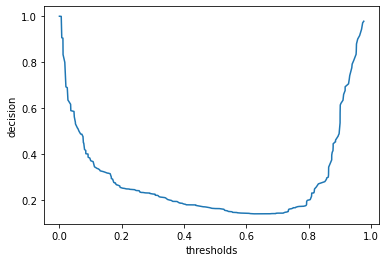

In [42]:
sns.lineplot(x = 'thresholds', y = 'decision', data = roc_result)

In [43]:
min_loss = min(func_value)
min_loss_index = roc_result.decision.idxmin()

optimal_threshold=roc_result.thresholds[roc_result.decision.idxmin()] 
optimal_index = roc_result.index[roc_result.thresholds==optimal_threshold]
#roc_result.best.idxmax()는 best값이 max 일때의 index를 의미
optimal_threshold

0.6616428033157498

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


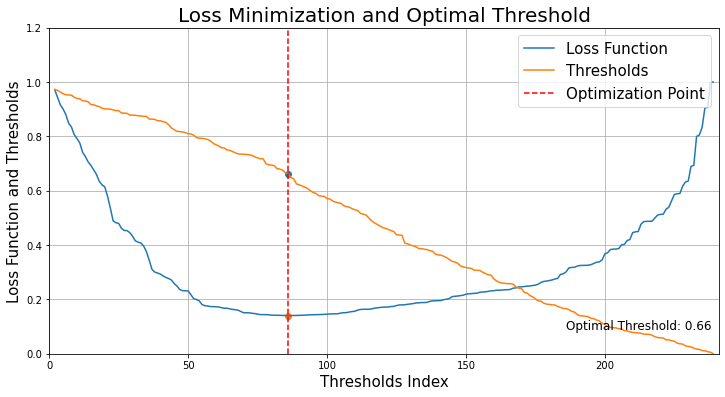

In [44]:
plt.figure(figsize=(12,6))
plt.plot(roc_result.index[1:], roc_result.decision[1:], label='Loss Function')
plt.plot(roc_result.index[1:], roc_result.thresholds[1:], label='Thresholds')
plt.scatter(optimal_index, optimal_threshold)
plt.scatter(min_loss_index, min_loss)
plt.plot([min_loss_index, min_loss_index], [0, 1.2], c='red', linestyle='--', label='Optimization Point')
plt.text(x=roc_result.decision.idxmin()+100, y=min_loss-0.05, s='Optimal Threshold: {:.2f}'.format(optimal_threshold), fontsize=12)
plt.xlim([0, 241])
plt.ylim([0,1.2])
plt.xlabel('Thresholds Index', fontsize=15)
plt.ylabel('Loss Function and Thresholds', fontsize=15)
plt.title('Loss Minimization and Optimal Threshold', fontsize=20)
plt.grid()
plt.legend(loc='upper right',fontsize=15)
plt.show()

In [45]:
test_result = pd.DataFrame(tree_final_fit.predict_proba(df_test_x))
test_result.head()

,0,1
0,0.546419,0.453581
1,0.953282,0.046718
2,0.915556,0.084444
3,0.982733,0.017267
4,0.562207,0.437793


In [46]:
## Confusion Matrix
#각 모형 별로 optimal threshold를 이용하여 binary (0 or 1) 로 예측
test_result['dt_binary']=np.where(test_result.iloc[:,1:2]>=optimal_threshold,1,0)

/Users/minseong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minseong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minseong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minseong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minseong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54872 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minseong/opt/anaconda3/lib/python3.9/site-p

<AxesSubplot:>

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


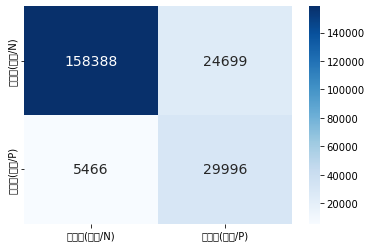

In [47]:
test_dt_con = confusion_matrix(df_test_y, test_result.dt_binary)
test_df_con = pd.DataFrame(test_dt_con, index = ['실제값(상환/N)', '실제값(부도/P)'], columns = ['예측값(상환/N)', '예측값(부도/P)'])
sns.heatmap(test_df_con, annot = True, fmt = 'd', cmap = 'Blues', annot_kws = {'size' : 14})

In [48]:
#roc_curve 계산
fpr,tpr,thresholds=roc_curve(df_test_y, test_result['dt_binary'])
roc_auc = auc(fpr, tpr)
tn, fp, fn, tp = confusion_matrix(df_test_y, test_result.dt_binary).ravel() #ravel은 1차원으로 만들어주는 함수를 의미함.
print(fpr, tpr)

[0.         0.13490308 1.        ] [0.         0.84586318 1.        ]


In [49]:
print('AUC score : ', round(auc(fpr, tpr), 3))
print('F1-Score : ', round(f1_score(df_test_y, test_result['dt_binary']), 3))
print('Precision score : ', round(precision_score(df_test_y, test_result['dt_binary']), 3))
print('Recall score :', round(recall_score(df_test_y, test_result['dt_binary']), 3))
print('Accuracy : ', round(((tn + tp) / (tn + fp + fn + tp)), 3))

AUC score :  0.855
F1-Score :  0.665
Precision score :  0.548
Recall score : 0.846
Accuracy :  0.862


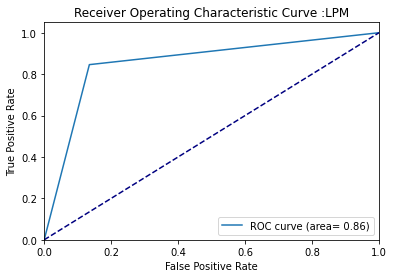

In [50]:
#ROC 커브 그래프에 나타내기

#그래프 그리기 시작
plt.figure()
#x축, y축 지정해주기
plt.plot(fpr, tpr, label='ROC curve (area= %0.2f)' % roc_auc)

##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve :LPM')
plt.legend(loc="lower right")

plt.show()

### 일반 모형

In [51]:
fpr2,tpr2,thresholds2=roc_curve(df_test_y, test_result.iloc[:,1:2])

In [52]:
#최적 threshold 찾기 

#fpr, tpr, threshold 로 구성된 dataframe 생성하기
roc_result = pd.DataFrame([fpr2,tpr2,thresholds2], index=['fpr','tpr','thresholds']).T
# (1-fpr)+(tpr)값을 계산하여 'best'라는 이름의 칼럼 생성하기
roc_result['best'] = (1-roc_result.fpr)+(roc_result.tpr) # specificity + sensitivity
# 이 best를 계산하는 방법은 여러가지가 있습니다. 우리는 Youden Index를 기준으로 합니다. (정답은 없음)
roc_result.head(20)

,fpr,tpr,thresholds,best
0,0.000000,0.000000,1.976411,1.000000
1,0.000939,0.020839,0.976411,1.019900
2,0.001049,0.024364,0.972840,1.023315
3,0.002130,0.052620,0.969280,1.050490
4,0.003365,0.079832,0.963118,1.076467
5,0.003933,0.090942,0.956904,1.087010
6,0.005232,0.111020,0.952985,1.105788
7,0.006396,0.135836,0.952330,1.129440
8,0.007100,0.146805,0.951713,1.139705
9,0.008925,0.172974,0.943809,1.164049


In [53]:
#최적 threshold는 best의 값이 최대가 될 때의 threshold 값
optimal_threshold=roc_result.thresholds[roc_result.best.idxmax()] 
#roc_result.best.idxmax()는 best값이 max 일때의 index를 의미
optimal_threshold

0.5111111111111111

In [54]:
## Confusion Matrix
#각 모형 별로 optimal threshold를 이용하여 binary (0 or 1) 로 예측
test_result['dt_binary2']=np.where(test_result.iloc[:,1:2]>=optimal_threshold,1,0)

/Users/minseong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minseong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minseong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minseong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minseong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54872 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minseong/opt/anaconda3/lib/python3.9/site-p

<AxesSubplot:>

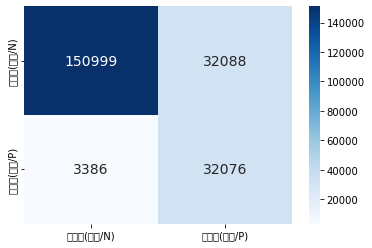

In [55]:
dt_con2 = confusion_matrix(df_test_y, test_result.dt_binary2)
df_con2 = pd.DataFrame(dt_con2, index = ['실제값(상환/N)', '실제값(부도/P)'], columns = ['예측값(상환/N)', '예측값(부도/P)'])
sns.heatmap(df_con2, annot = True, fmt = 'd', cmap = 'Blues', annot_kws = {'size' : 14})

In [56]:
fpr2,tpr2,thresholds2=roc_curve(df_test_y, test_result['dt_binary2'])
tn2, fp2, fn2, tp2 = confusion_matrix(df_test_y, test_result.dt_binary2).ravel() #ravel은 1차원으로 만들어주는 함수를 의미함.
roc_auc2 = auc(fpr2, tpr2)

In [57]:
print('AUC score : ', round(auc(fpr2, tpr2), 3))
print('F1-Score : ', round(f1_score(df_test_y, test_result['dt_binary2']), 3))
print('Precision score : ', round(precision_score(df_test_y, test_result['dt_binary2']), 3))
print('Recall score :', round(recall_score(df_test_y, test_result['dt_binary2']), 3))
print('Accuracy : ', round(((tn2 + tp2) / (tn2 + fp2 + fn2 + tp2)), 3))

AUC score :  0.865
F1-Score :  0.644
Precision score :  0.5
Recall score : 0.905
Accuracy :  0.838


In [58]:
report = classification_report(df_test_y, test_result['dt_binary2'])
print(report)

              precision    recall  f1-score   support

           0       0.98      0.82      0.89    183087
           1       0.50      0.90      0.64     35462

    accuracy                           0.84    218549
   macro avg       0.74      0.86      0.77    218549
weighted avg       0.90      0.84      0.85    218549



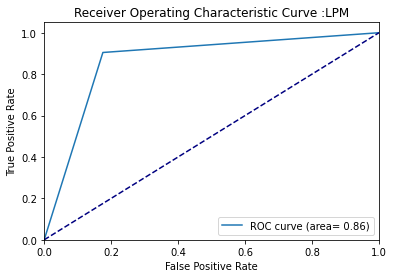

In [59]:
#ROC 커브 그래프에 나타내기

#그래프 그리기 시작
plt.figure()
#x축, y축 지정해주기
plt.plot(fpr2, tpr2, label='ROC curve (area= %0.2f)' % roc_auc2)

##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve :LPM')
plt.legend(loc="lower right")

plt.show()

### 변수 중요도

In [60]:
df_importance=pd.DataFrame()
df_importance['Feature']=x_train_res.columns
df_importance['Importance']=tree_final.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3).head(20)
df_importance_top10 = df_importance.head(10)
df_importance_top10.round(3)

,Feature,Importance
26,last_fico_score,0.960
0,loan_amnt,0.017
8,total_acc,0.005
2,dti,0.004
1,annual_inc,0.004
20,mths_since_rcnt_il,0.004
25,fico_score,0.001
7,revol_util,0.001
34,verification_status_2,0.001
12,tot_cur_bal,0.001


/Users/minseong/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Text(0, 0.5, '변수')

/Users/minseong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minseong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minseong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minseong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minseong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/minseong/opt/anaconda3/lib/python3.9/site-p

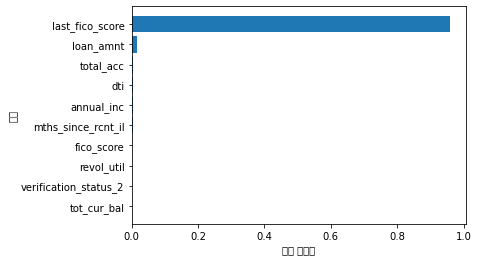

In [61]:
df_importance_top10.sort_values('Importance', ascending=True, inplace=True)
coordinates=range(len(df_importance_top10))
plt.barh(y=coordinates, width=df_importance_top10['Importance'])
plt.yticks(coordinates, df_importance_top10['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

### 전체 결과

In [62]:
auc_score = [0.78, 0.889, 0.847, 0.894, ]
f1_score = [0.624, 0.666, 0.713, 0.688]
precision = [0.619, 0.519, 0.672, 0.55]
recall = [0.629, 0.93, 0.759, 0.92]
accuracy = [0.887, 0.861, 0.909, 0.875]

df_eval = pd.DataFrame(index = ['Random Forest Custom', 'Random Forest', 'Tree Custom', 'Tree Original'])
df_eval['auc_score'] = auc_score
df_eval['f1_score'] = f1_score
df_eval['precision'] = precision
df_eval['recall'] = recall
df_eval['accuracy'] = accuracy
df_eval

,auc_score,f1_score,precision,recall,accuracy
Random Forest Custom,0.780,0.624,0.619,0.629,0.887
Random Forest,0.889,0.666,0.519,0.930,0.861
Tree Custom,0.847,0.713,0.672,0.759,0.909
Tree Original,0.894,0.688,0.550,0.920,0.875


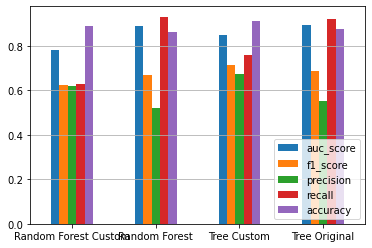

In [63]:
df_eval.plot.bar(rot = 0)
plt.legend(loc = 'lower right')
plt.grid(axis = 'y')

In [64]:
df_eval.index

Index(['Random Forest Custom', 'Random Forest', 'Tree Custom',
       'Tree Original'],
      dtype='object')

In [65]:
auc_score = [0.884, 0.888]
f1_score = [0.705, 0.679]
precision = [0.587, 0.538]
recall = [0.883, 0.92]
accuracy = [0.886, 0.865]

df_eval = pd.DataFrame(index = ['Tree Custom', 'Tree Original'])
df_eval['auc_score'] = auc_score
df_eval['f1_score'] = f1_score
df_eval['precision'] = precision
df_eval['recall'] = recall
df_eval['accuracy'] = accuracy
df_eval

,auc_score,f1_score,precision,recall,accuracy
Tree Custom,0.884,0.705,0.587,0.883,0.886
Tree Original,0.888,0.679,0.538,0.920,0.865


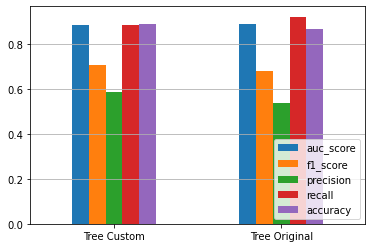

In [66]:
df_eval.plot.bar(rot = 0)
plt.legend(loc = 'lower right')
plt.grid(axis = 'y')